Sample code for computing Performance Profiles for different methods on the Arcade Learning Environment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import betainc

In [2]:
def poor_man_welch_test(target_mean,target_std,target_n,comp_mean,comp_std,comp_n):
    # Computes a Welch test to see if the comparitor sample is larger than the target 
    # sample. This is a one-sided test.
    # This works from sufficient statistics alone, and that's because this is all that 
    # people report in their papers. I'm no more happy about this than you are.
    
    nu = ((target_std**2/target_n + comp_std**2/comp_n)**2/
         (target_std**4/target_n/(target_n-1)+ comp_std**4/comp_n/(comp_n-1)))
    t_stat = ((target_mean-comp_mean)
              /np.sqrt(target_std**2/target_n+comp_std**2/comp_n))
            
    return 0.5*betainc(nu/2,1/2,nu/(t_stat**2+nu))

def optimality_deviation(data_means,data_std,data_n):
    # compute the deviation from optimality as given by the log-likehood of a Welch t-test 
    num_prob, num_method = data_means.shape
    likelihood = np.zeros((num_prob,num_method))    
    for prob in range(num_prob):
        best_idx = np.argmax(data_means[prob,:])

        # compute the Welsh t-test to determine the p-value associated 
        # with a method having mean higher than the observed highest reward
        for method in range(num_method):
            likelihood[prob,method] = -np.log10(poor_man_welch_test(
                                        data_means[prob,best_idx],data_std[prob,best_idx],data_n[prob,best_idx],
                                        data_means[prob,method],data_std[prob,method],data_n[prob,method]))

        # denote the likelihood of the best observation as being 1. This is merely counting 
        # the number of times a method achieves the highest mean.
        likelihood[prob,best_idx] = 0
    return likelihood

def welch_t_perf_prof(data_means,data_std,data_n,data_names,tau_min=0.3,tau_max=3.0,npts=100):
    num_prob, num_method = data_means.shape
    rho = np.zeros((npts,num_method))
    
    # This is the d[p,m] function discussed in the blog.
    # For this post, I'm using the log-likelihood of the Welch t-test. 
    # But this is where you'd write whatever method you think would work better.
    dist_like_fun = optimality_deviation(data_means,data_std,data_n)
             
    # Compute the cumulative rates of the distance being less than a fixed threshold
    tau = np.linspace(tau_min,tau_max,npts)
    for method in range(num_method):
        for k in range(npts):
            rho[k,method] = np.sum(dist_like_fun[:,method]<tau[k])/num_prob
    
    # make plot
    colors = [ '#2D328F', '#F15C19',"#81b13c","#ca49ac","000000"]
    label_fontsize = 18
    tick_fontsize = 14
    linewidth = 3
    plt.figure(figsize=(20,10))    
    for method in range(num_method):
        plt.plot(tau,rho[:,method],color=colors[method],linewidth=linewidth,label=data_names[method])

    plt.xlabel(r'$-\log_{10}(\tau)$',fontsize=label_fontsize)
    plt.ylabel(r'fraction with $p_{val} \geq \tau$',fontsize=label_fontsize)
    plt.legend(fontsize=label_fontsize,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)

    plt.grid(True)
    plt.show()

Data for Sarsa$(\lambda)$ and DQN comes from the Tables 8 and 9 from paper “Revisiting the Arcade Learning Environment: Evaluation Protocols and Open Problems for General Agents.” https://arxiv.org/abs/1709.06009

The DQN data is in [this file.](dqn.data)
The Blob-PROST data is in [this file.](sarsa-blob.data)

The data for humans, and planners obtaied from Blai Bonet's [GitHub repo](https://github.com/bonetblai/rollout-iw).

## Data Loading

In [3]:
import pandas as pd
from re import sub
from decimal import Decimal

In [4]:
blob = pd.read_csv('sarsa-blob.data',sep = ' ')

In [5]:
blob.columns

Index(['Game', '10M_frames_Mean', '10M_frame_StdDev', '50M_frames_Mean',
       '50M_frames_StdDev', '100M_frames_Mean', '100M_frames_StdDev',
       '200M_frames_Mean', '200M_frames_StdDev'],
      dtype='object')

In [6]:
blob.head()

,Game,10M_frames_Mean,10M_frame_StdDev,50M_frames_Mean,50M_frames_StdDev,100M_frames_Mean,100M_frames_StdDev,200M_frames_Mean,200M_frames_StdDev
0,Alien,"1,910.2",557.4,"3,255.3",562.8,"3,753.5",712.0,"4,272.7",773.2
1,Amidar,210.4,42.6,332.3,64.6,414.6,84.2,411.4,177.4
2,Assault,435.9,94.8,651.9,148.7,851.7,185.4,"1,049.4",182.7
3,Asterix,"2,146.8",364.8,"3,417.8",445.3,"3,767.8",354.9,"4,358.0",431.6
4,Asteroids,"1,350.1",259.5,"1,378.1",233.0,"1,443.4",218.1,"1,524.1",191.2


In [7]:
dqn = pd.read_csv('dqn.data', sep='\s+')

In [8]:
dqn.head()

,Game,10M_frames_Mean,10M_frame_StdDev,50M_frames_Mean,50M_frames_StdDev,100M_frames_Mean,100M_frames_StdDev,200M_frames_Mean,200M_frames_StdDev
0,Alien,600.5,23.6,"1,426.6",81.6,"1,952.6",216.0,"2,742.0",357.5
1,Amidar,91.6,10.5,414.2,53.6,621.6,92.6,792.6,220.4
2,Assault,688.9,16.0,"1,327.5",83.9,"1,433.9",126.6,"1,424.6",106.8
3,Asterix,"1,732.6",314.6,"3,122.6",96.4,"3,423.4",213.6,"2,866.8","1,354.6"
4,Asteroids,301.4,14.3,458.1,28.5,458.0,18.9,528.5,37.0


In [9]:
bandres = pd.read_csv('bandres_table_2.dat', sep='\s+')

In [10]:
bandres.columns

Index(['rom', 'human', 'ram', 'bfs.011.15.5s', 'bfs.011.15.32s',
       'roll.011.15.5s', 'roll.011.15.32s', 'roll.010.15.5s',
       'roll.010.15.32s', 'roll.110.15.5s', 'roll.110.15.32s', 'best.score'],
      dtype='object')

In [11]:
bandres.columns = ['Game', 'human', 'ram', 'bfs.011.15.5s', 'bfs.011.15.32s',
       'roll.011.15.5s', 'roll.011.15.32s', 'roll.010.15.5s',
       'roll.010.15.32s', 'roll.110.15.5s', 'roll.110.15.32s', 'best.score']

In [12]:
bandres.head()

,Game,human,ram,bfs.011.15.5s,bfs.011.15.32s,roll.011.15.5s,roll.011.15.32s,roll.010.15.5s,roll.010.15.32s,roll.110.15.5s,roll.110.15.32s,best.score
1,asterix,"8,503.0","153,400.0","1,350.0","262,500.0","45,780.0","66,100.0","46,100.0","67,100.0","48,700.0","87,600.0","262,500.0"
2,beamrider,"5,775.0","9,108.0",715.2,"1,530.4","2,188.0","2,464.8","2,552.8","5,367.2","3,729.2","4,921.2","9,108.0"
3,breakout,31.8,384.0,1.6,56.0,82.4,36.0,86.2,336.4,79.8,370.0,384.0
4,enduro,309.6,500.0,2.6,229.2,169.4,359.4,145.8,381.0,137.4,330.8,500.0
5,freeway,29.6,31.0,0.6,25.0,2.8,12.6,2.0,11.2,3.6,10.0,31.0


In [13]:
merged = pd.merge(blob,dqn,on='Game',suffixes=('_blob','_dqn'))
# The next line converts every entry on the 'Game' column to lower case
merged = merged.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)
merged.head()

,Game,10M_frames_Mean_blob,10M_frame_StdDev_blob,50M_frames_Mean_blob,50M_frames_StdDev_blob,100M_frames_Mean_blob,100M_frames_StdDev_blob,200M_frames_Mean_blob,200M_frames_StdDev_blob,10M_frames_Mean_dqn,10M_frame_StdDev_dqn,50M_frames_Mean_dqn,50M_frames_StdDev_dqn,100M_frames_Mean_dqn,100M_frames_StdDev_dqn,200M_frames_Mean_dqn,200M_frames_StdDev_dqn
0,alien,"1,910.2",557.4,"3,255.3",562.8,"3,753.5",712.0,"4,272.7",773.2,600.5,23.6,"1,426.6",81.6,"1,952.6",216.0,"2,742.0",357.5
1,amidar,210.4,42.6,332.3,64.6,414.6,84.2,411.4,177.4,91.6,10.5,414.2,53.6,621.6,92.6,792.6,220.4
2,assault,435.9,94.8,651.9,148.7,851.7,185.4,"1,049.4",182.7,688.9,16.0,"1,327.5",83.9,"1,433.9",126.6,"1,424.6",106.8
3,asterix,"2,146.8",364.8,"3,417.8",445.3,"3,767.8",354.9,"4,358.0",431.6,"1,732.6",314.6,"3,122.6",96.4,"3,423.4",213.6,"2,866.8","1,354.6"
4,asteroids,"1,350.1",259.5,"1,378.1",233.0,"1,443.4",218.1,"1,524.1",191.2,301.4,14.3,458.1,28.5,458.0,18.9,528.5,37.0


In [14]:
all_db = pd.merge(merged,bandres,on='Game')
all_db.head()

,Game,10M_frames_Mean_blob,10M_frame_StdDev_blob,50M_frames_Mean_blob,50M_frames_StdDev_blob,100M_frames_Mean_blob,100M_frames_StdDev_blob,200M_frames_Mean_blob,200M_frames_StdDev_blob,10M_frames_Mean_dqn,...,ram,bfs.011.15.5s,bfs.011.15.32s,roll.011.15.5s,roll.011.15.32s,roll.010.15.5s,roll.010.15.32s,roll.110.15.5s,roll.110.15.32s,best.score
0,alien,"1,910.2",557.4,"3,255.3",562.8,"3,753.5",712.0,"4,272.7",773.2,600.5,...,"25,634.0","1,316.0","14,010.0","4,238.0","6,896.0","7,170.0","13,454.0","8,550.0","19,354.0","25,634.0"
1,amidar,210.4,42.6,332.3,64.6,414.6,84.2,411.4,177.4,91.6,...,"1,377.0",48.0,"1,043.2",659.8,"1,698.6","1,049.2","1,794.0","1,161.0","1,609.0","1,794.0"
2,assault,435.9,94.8,651.9,148.7,851.7,185.4,"1,049.4",182.7,688.9,...,953.0,268.8,336.0,285.6,319.2,336.0,327.6,264.6,281.4,"1,496.0"
3,asterix,"2,146.8",364.8,"3,417.8",445.3,"3,767.8",354.9,"4,358.0",431.6,"1,732.6",...,"153,400.0","1,350.0","262,500.0","45,780.0","66,100.0","46,100.0","67,100.0","48,700.0","87,600.0","262,500.0"
4,asteroids,"1,350.1",259.5,"1,378.1",233.0,"1,443.4",218.1,"1,524.1",191.2,301.4,...,"51,338.0",840.0,"7,630.0","4,344.0","7,258.0","4,698.0","6,836.0","4,486.0","7,344.0","51,338.0"


In [15]:
def f(x) :
    if str(x) == 'nan' :
        return 0.0
    #print(x)
    #print(sub(r'[^\d.]', '', str(x)))
    return float(sub(r'[^\d.]', '', str(x)))

for col in all_db.columns:
    if col != 'Game':
        all_db[col]=all_db[col].apply( f )

In [16]:
all_db.head()

,Game,10M_frames_Mean_blob,10M_frame_StdDev_blob,50M_frames_Mean_blob,50M_frames_StdDev_blob,100M_frames_Mean_blob,100M_frames_StdDev_blob,200M_frames_Mean_blob,200M_frames_StdDev_blob,10M_frames_Mean_dqn,...,ram,bfs.011.15.5s,bfs.011.15.32s,roll.011.15.5s,roll.011.15.32s,roll.010.15.5s,roll.010.15.32s,roll.110.15.5s,roll.110.15.32s,best.score
0,alien,1910.2,557.4,3255.3,562.8,3753.5,712.0,4272.7,773.2,600.5,...,25634.0,1316.0,14010.0,4238.0,6896.0,7170.0,13454.0,8550.0,19354.0,25634.0
1,amidar,210.4,42.6,332.3,64.6,414.6,84.2,411.4,177.4,91.6,...,1377.0,48.0,1043.2,659.8,1698.6,1049.2,1794.0,1161.0,1609.0,1794.0
2,assault,435.9,94.8,651.9,148.7,851.7,185.4,1049.4,182.7,688.9,...,953.0,268.8,336.0,285.6,319.2,336.0,327.6,264.6,281.4,1496.0
3,asterix,2146.8,364.8,3417.8,445.3,3767.8,354.9,4358.0,431.6,1732.6,...,153400.0,1350.0,262500.0,45780.0,66100.0,46100.0,67100.0,48700.0,87600.0,262500.0
4,asteroids,1350.1,259.5,1378.1,233.0,1443.4,218.1,1524.1,191.2,301.4,...,51338.0,840.0,7630.0,4344.0,7258.0,4698.0,6836.0,4486.0,7344.0,51338.0


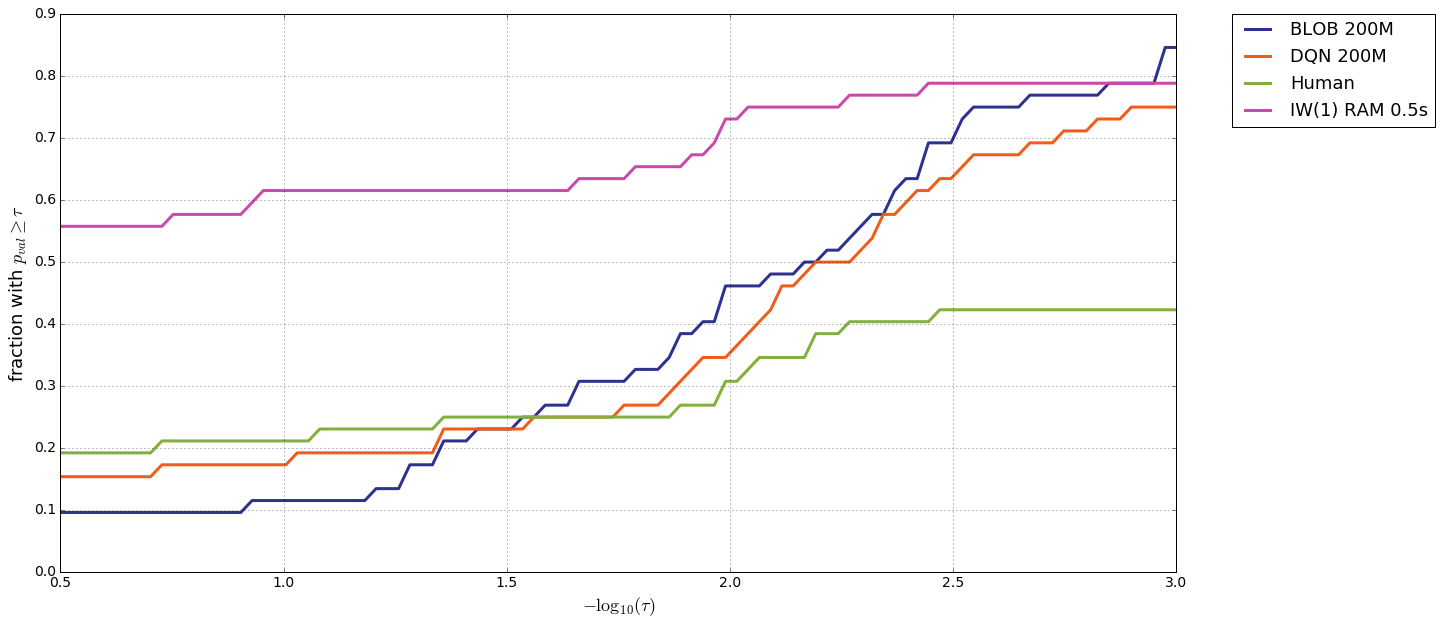

In [17]:
data_means = np.vstack( (all_db['200M_frames_Mean_blob'], all_db['200M_frames_Mean_dqn'], all_db['human'], all_db['ram'])).T
fake_std = np.zeros((1,len(all_db['200M_frames_Mean_blob'])))
data_std = np.vstack((all_db['200M_frames_StdDev_blob'], all_db['200M_frames_StdDev_dqn'], fake_std, fake_std)).T + 1e-6
data_n = np.tile(np.array([24,24,5,5]).T,[60,1])
data_names = ['BLOB 200M', 'DQN 200M', 'Human', 'IW(1) RAM 0.5s']
welch_t_perf_prof(data_means,data_std,data_n,data_names,tau_min=0.5,tau_max=3)

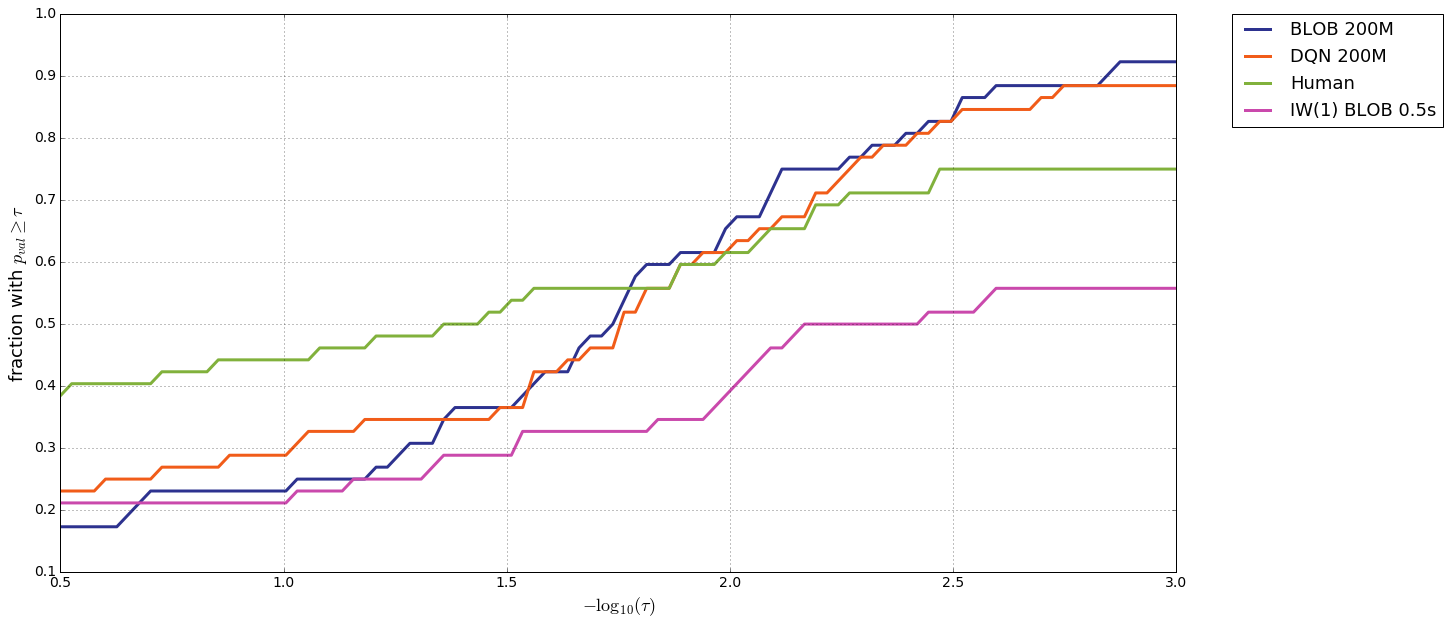

In [18]:
data_means = np.vstack( (all_db['200M_frames_Mean_blob'], all_db['200M_frames_Mean_dqn'], all_db['human'], all_db['bfs.011.15.5s'])).T
fake_std = np.zeros((1,len(all_db['200M_frames_Mean_blob'])))
data_std = np.vstack((all_db['200M_frames_StdDev_blob'], all_db['200M_frames_StdDev_dqn'], fake_std, fake_std)).T + 1e-6
data_n = np.tile(np.array([24,24,5,5]).T,[60,1])
data_names = ['BLOB 200M', 'DQN 200M', 'Human', 'IW(1) BLOB 0.5s']
welch_t_perf_prof(data_means,data_std,data_n,data_names,tau_min=0.5,tau_max=3)

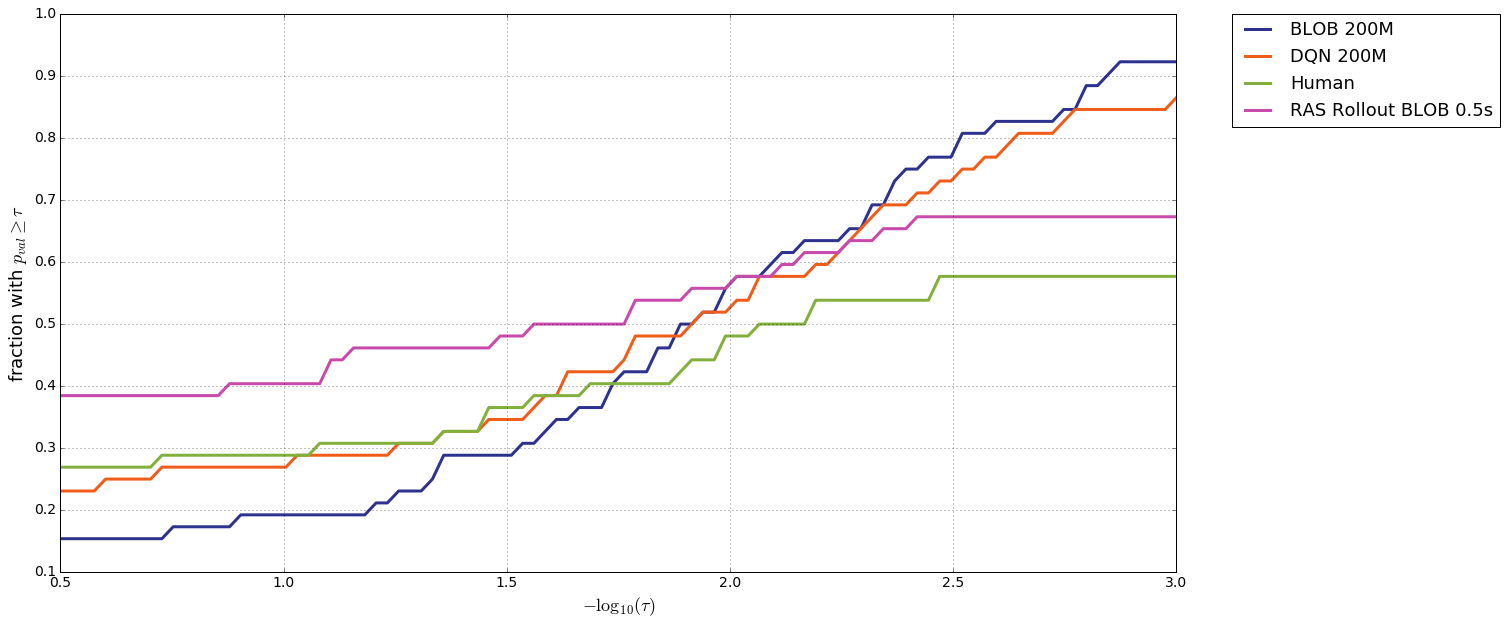

In [19]:
data_means = np.vstack( (all_db['200M_frames_Mean_blob'], all_db['200M_frames_Mean_dqn'], all_db['human'], all_db['roll.110.15.5s'])).T
fake_std = np.zeros((1,len(all_db['200M_frames_Mean_blob'])))
data_std = np.vstack((all_db['200M_frames_StdDev_blob'], all_db['200M_frames_StdDev_dqn'], fake_std, fake_std)).T + 1e-6
data_n = np.tile(np.array([24,24,5,5]).T,[60,1])
data_names = ['BLOB 200M', 'DQN 200M', 'Human', 'RAS Rollout BLOB 0.5s']
welch_t_perf_prof(data_means,data_std,data_n,data_names,tau_min=0.5,tau_max=3)